# Adapting BYT5 for Token Classification + NEFT
This notebook is for developing a general framework for multilingual token classification tasks. With a baseline task of POS tagging in English, it involves the development and implementation of the following:

- Preprocessing and postprocessing logic for mapping Conditional Generation to a Token Classification task
- A Custom loss function for encouraging predicitions to avoid a specified tag during fine tuning (useful if your tagset has an UNK style tag)
- Noisy Embedding Fine Tuning
- A classification metric evaluation procedure for unstructed model generations that is slightly robust to poorly structured output

The choice of ByT5 is due to the following:
- The ByT5 paper gives evidence that Byte-based models are particularly suited to tasks that operate below the token level. I would argue that token classification is one such task as it is essentially reasoning with incredibly small sequences.
- Byte models have also shown evidence to be more robust to noise. In a regular tokenizer, a wrong character can result in a completely different subword and therefore embedding. Since bytes are already the smallest unit, they cannot be purturbed in this way.
- The small version of the model is still exactly that - relatively small being only 300M params and ~1.2GB.
- One noted capability of the byte model is that by nature the vocab size is 100x smaller than what modern tokenizers usually produce. This allows the excess parameters to be used in the knowledge/reasoning parameters like attention and so a 300M param byte model actually has the hidden layer capacity of a larger model.
- To me, using bytes as tokens also makes the model more language agnostic since there is no potential language-bias in learning the tokenization patterns as with things like sentence piece.

Notes:
- You may notice that validation loss is consistently lower than training loss. I put this down to (from intuition not thorough exploration) dropout being used during training but not during validation.

- During initial testing, PEFT methods such as LORA drastically reduced performance, especially where giving the correctly structured output was concerned. I therefore opted for a full fine tune given that the model is already relatively small. In future, it is probably worth reevaluating PEFT as an option as it was only explored in a very very limited capacity here.

In [ ]:
%%capture
!pip install transformers datasets
!pip install transformers[torch]
!pip install numpy
!pip install scikit-learn

In [ ]:
from transformers import T5ForConditionalGeneration, AutoTokenizer, Trainer, TrainingArguments, DataCollatorForSeq2Seq
from datasets import load_dataset, Dataset, concatenate_datasets, DatasetDict
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score, accuracy_score
import torch.nn as nn
from string import punctuation
from torch.nn import CrossEntropyLoss
from collections import Counter
import matplotlib.pyplot as plt
import json
import string
from functools import wraps

In [ ]:
try:
  dev = torch.cuda.current_device()
  print(torch.cuda.get_device_name(dev))
except RuntimeError:
  dev = "cpu"

Tesla T4


In [ ]:
data = load_dataset("batterydata/pos_tagging")
data["val"] = Dataset.from_dict(data["train"][8000:])
data["train"] = Dataset.from_dict(data["train"][:8000])
data["test"] = Dataset.from_dict(data["test"][:1000])
data.shape

{'train': (8000, 2), 'test': (1000, 2), 'val': (5054, 2)}

In [ ]:
def punct_label(x):
  x["labels"] = [lab if all([char not in punctuation for char in lab]) else "PUNC" for lab in x["labels"]]
  return x

data = data.map(punct_label)

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5054 [00:00<?, ? examples/s]

In [ ]:
tagset = sorted(list(set([item for sublist in data["train"]["labels"] for item in sublist])))
label2id = {k:i for i,k in enumerate(tagset)}
id2label = {v:k for k,v in label2id.items()}
id2label

{0: 'CC',
 1: 'CD',
 2: 'DT',
 3: 'EX',
 4: 'FW',
 5: 'IN',
 6: 'JJ',
 7: 'JJR',
 8: 'JJS',
 9: 'MD',
 10: 'NN',
 11: 'NNP',
 12: 'NNPS',
 13: 'NNS',
 14: 'PDT',
 15: 'POS',
 16: 'PRP',
 17: 'PUNC',
 18: 'RB',
 19: 'RBR',
 20: 'RBS',
 21: 'RP',
 22: 'SYM',
 23: 'TO',
 24: 'UH',
 25: 'VB',
 26: 'VBD',
 27: 'VBG',
 28: 'VBN',
 29: 'VBP',
 30: 'VBZ',
 31: 'WDT',
 32: 'WP',
 33: 'WRB'}

In [ ]:
model_path = "google/byt5-small"
model = T5ForConditionalGeneration.from_pretrained(model_path)

tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.max_length = 512
tokenizer.pad_token_id

0

Text(0.5, 1.0, 'Tag Proportions')

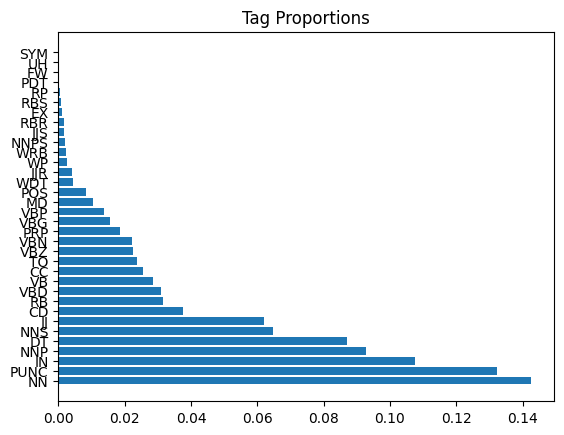

In [ ]:
tag_counts = Counter([item for sublist in data["train"]["labels"] for item in sublist]).most_common()
x,y = list(zip(*tag_counts))
y= np.array(y)/sum(y)
plt.barh(x,y)
plt.title("Tag Proportions")

In [ ]:
data["train"].features

{'words': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [ ]:
def preprocess_inputs(example, token_col="words", tag_col="labels", task_prefix="TAG:"): # originally 'topic tag:'
    example["input_sequence"] = task_prefix + " ".join(example[token_col])
    example.update(tokenizer(example['input_sequence'], truncation=True, padding="max_length", max_length=tokenizer.max_length, return_tensors="pt"))
    example["input_ids"] = example["input_ids"].squeeze()
    return example

def preprocess_labels(example, token_col="words", tag_col="labels"):
  seq = ""
  for tok, tag in zip(example[token_col], example[tag_col]):
    if type(tag) == int:
      tag = id2label[tag]
    seq += f"{tag}>:> {tok}>;> " # do not remove the space

  seq = seq[:-1]

  example["target_seq"] = seq
  example["str_labels"] = example[tag_col]

  return example


def label_tokenizer(x):
  outputs = tokenizer(x['target_seq'], truncation=True, padding="max_length", max_length=tokenizer.max_length, return_tensors="pt")
  outputs["labels"] = outputs.pop("input_ids").squeeze()
  outputs["decoder_attention_mask"] = outputs.pop("attention_mask")
  return outputs

def preprocess_data(example):
  example = preprocess_inputs(example)
  example = preprocess_labels(example)
  example = label_tokenizer(example)
  return example

In [ ]:
data = data.map(lambda example: preprocess_data(example))
data

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5054 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['words', 'labels', 'input_sequence', 'input_ids', 'attention_mask', 'target_seq', 'str_labels', 'decoder_attention_mask'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['words', 'labels', 'input_sequence', 'input_ids', 'attention_mask', 'target_seq', 'str_labels', 'decoder_attention_mask'],
        num_rows: 1000
    })
    val: Dataset({
        features: ['words', 'labels', 'input_sequence', 'input_ids', 'attention_mask', 'target_seq', 'str_labels', 'decoder_attention_mask'],
        num_rows: 5054
    })
})

In [ ]:
data["train"][0]["target_seq"]

"NN>:> Confidence>;> IN>:> in>;> DT>:> the>;> NN>:> pound>;> VBZ>:> is>;> RB>:> widely>;> VBN>:> expected>;> TO>:> to>;> VB>:> take>;> DT>:> another>;> JJ>:> sharp>;> NN>:> dive>;> IN>:> if>;> NN>:> trade>;> NNS>:> figures>;> IN>:> for>;> NNP>:> September>;> PUNC>:> ,>;> JJ>:> due>;> IN>:> for>;> NN>:> release>;> NN>:> tomorrow>;> PUNC>:> ,>;> VB>:> fail>;> TO>:> to>;> VB>:> show>;> DT>:> a>;> JJ>:> substantial>;> NN>:> improvement>;> IN>:> from>;> NNP>:> July>;> CC>:> and>;> NNP>:> August>;> POS>:> 's>;> JJ>:> near-record>;> NNS>:> deficits>;> PUNC>:> .>;>"

In [ ]:
def flatten(l):
    return [item for sublist in l for item in sublist]


def remove_punctuation(input_string):
    translator = str.maketrans("", "", string.punctuation)
    return input_string.translate(translator)


def parse_output(predictions: list[str], labels: list[str]) -> tuple[list[str], list[str]]:
    pred_out = []
    lab_out = []
    for pred, lab in zip(predictions, labels):
      pred_items = pred.split(">;>")
      lab_items = lab.split(">;>")
      pred_labels = [remove_punctuation(i.split(">:>")[0]).strip() for i in pred_items if i]
      lab_labels = [i.split(">:>")[0].strip() for i in lab_items]

      # hacky padding and truncation
      if len(pred_labels) > len(lab_labels):
        pred_labels = pred_labels[:len(lab_labels)] # truncating
      elif len(pred_labels) < len(lab_labels):
        pred_labels.extend((len(lab_labels) - len(pred_labels)) * [""]) # padding

      pred_out.extend(pred_labels)
      lab_out.extend(lab_labels)

    return pred_out, lab_out

@torch.no_grad()
def compute_metrics(p):

    eval_tags = tagset.copy()
    eval_tags.remove("PUNC") # TODO: CHANGE TO Z99 etc.

    predictions, labels = p.predictions, p.label_ids

    predictions = np.argmax(predictions[0], axis=-1)
    predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    true_predictions, true_labels = parse_output(predictions, labels)

    with open("predictions.log", "a") as f:
      print(true_predictions, true_labels, file=f)

    return {
        "macro_f1": f1_score(y_true=true_labels, y_pred=true_predictions, average="macro", labels=eval_tags),
        "macro_precision": precision_score(y_true=true_labels, y_pred=true_predictions, average="macro", labels=eval_tags),
        "macro_recall": recall_score(y_true=true_labels, y_pred=true_predictions, average="macro", labels=eval_tags),
        "accuracy": accuracy_score(y_true=true_labels, y_pred=true_predictions),
        "micro_f1": f1_score(y_true=true_labels, y_pred=true_predictions, average="micro", labels=eval_tags),
        "micro_precision": precision_score(y_true=true_labels, y_pred=true_predictions, average="micro", labels=eval_tags),
        "micro_recall": recall_score(y_true=true_labels, y_pred=true_predictions, average="micro", labels=eval_tags),
        }



In [ ]:
ignore_tag = "PUNC" #Z99
ignore_span = tokenizer(ignore_tag, add_special_tokens=False, return_tensors="pt").input_ids
ignore_span = ignore_span.to(dev)
penalty = -torch.tensor(1/len(tokenizer)).log() #~5 for this data with 384 tokens. This is the loss if all possible token ids had uniform distribution
torch.autograd.set_detect_anomaly(True)
from transformers.modeling_utils import unwrap_model

class TagPenaltyTrainerWithNEFT(Trainer):

    def __init__(self,
                 ignore_span: torch.Tensor,
                 penalty:float=5.0,
                 neftune_noise_alpha:float or None=5.0,
                 *args,
                 **kwargs):

            super().__init__(*args, **kwargs)
            self.penalty = penalty
            self.ignore_span = ignore_span
            self.neftune_noise_alpha = neftune_noise_alpha

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")

        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]
        decoder_attention_mask = inputs["decoder_attention_mask"]

        outputs = model(input_ids=input_ids, attention_mask=attention_mask,
                        decoder_attention_mask=decoder_attention_mask, labels=labels)

        logits = outputs.logits # (batch_size, sequence_length, vocabulary_size) (4, 512, 384)
        loss_fct = CrossEntropyLoss(ignore_index=0, reduction="none") #TODO: programmatically get model.config.pad_token_id
        loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1)) # Cast both to shape (2048)

        output_ids = torch.argmax(outputs.logits, dim=-1)
        mask = torch.ones_like(output_ids)

        for i in range(output_ids.size(0)):
            for j in range(output_ids.size(1) - len(self.ignore_span) + 1):
                if torch.all(output_ids[i, j:j+len(self.ignore_span)] == self.ignore_span):
                    mask[i, j:j+len(self.ignore_span)] = self.penalty
                  # also add check for correct structure?

        loss = loss.view(logits.shape[0],logits.shape[1])
        loss += mask
        loss = loss.view(-1).mean()

        return (loss, outputs) if return_outputs else loss

    @wraps(Trainer.train)
    def train(self, *args, **kwargs):
        """
        Adapted from:https://github.com/huggingface/trl/blob/9e9f024399b76842ece3552884bbc4f304fd4153/trl/trainer/sft_trainer.py#L274C1-L274C1
        Adds functionality for Noisy Embedding FineTuning
        """
        # Activate neftune right before training.
        if self.neftune_noise_alpha is not None: #and not self._trainer_supports_neftune:
            self.model = self._trl_activate_neftune(self.model)

        output = super().train(*args, **kwargs)

        # After training we make sure to retrieve back the original forward pass method
        # for the embedding layer by removing the forward post hook.
        if self.neftune_noise_alpha is not None: # and not self._trainer_supports_neftune:
            unwrapped_model = unwrap_model(self.model)
            embeddings = unwrapped_model.get_input_embeddings()
            self.neftune_hook_handle.remove()
            del embeddings.neftune_noise_alpha

        return output

    def _trl_activate_neftune(self, model):
        """
        Adapted from: https://github.com/huggingface/trl/blob/9e9f024399b76842ece3552884bbc4f304fd4153/trl/trainer/sft_trainer.py#L379
        Activates the neftune as presented in this code: https://github.com/neelsjain/NEFTune and paper: https://arxiv.org/abs/2310.05914
        Since in transformers Trainer we do have an `_activate_neftune` method, we need to rename this method to avoid conflicts.
        """
        unwrapped_model = unwrap_model(model)
        embeddings = unwrapped_model.get_input_embeddings()

        embeddings.neftune_noise_alpha = self.neftune_noise_alpha
        hook_handle = embeddings.register_forward_hook(self.neftune_post_forward_hook)
        self.neftune_hook_handle = hook_handle
        return model

    @staticmethod
    def neftune_post_forward_hook(module, input, output):
      """
      Adapted from: https://github.com/huggingface/trl/blob/9e9f024399b76842ece3552884bbc4f304fd4153/trl/trainer/utils.py#L742
      """
      if module.training:
          dims = torch.tensor(output.size(1) * output.size(2))
          mag_norm = module.neftune_noise_alpha / torch.sqrt(dims)
          output = output + torch.zeros_like(output).uniform_(-mag_norm, mag_norm)
      return output


In [ ]:
datacollator = DataCollatorForSeq2Seq(tokenizer=tokenizer, padding="longest")

training_args = TrainingArguments(
        output_dir="test_byt5_pos",
        learning_rate= 3e-4, #recommended from thread
        per_device_train_batch_size = 1 if dev == "cpu" else 4,
        per_device_eval_batch_size = 1 if dev == "cpu" else 4,
        num_train_epochs=1,
        weight_decay=0.01,
        evaluation_strategy="steps",
        eval_steps = 250,
        save_strategy="epoch",
        #save_steps=400,
        #load_best_model_at_end=True,
        optim="adafactor", #adafactor was developed for T5
        warmup_steps=100,
        logging_steps=250,
        #report_to="tensorboard",
        #push_to_hub=True,
        #eval_delay=1,
    )


In [ ]:
trainer = TagPenaltyTrainerWithNEFT(
    model=model,
    args=training_args,
    data_collator = datacollator,
    train_dataset=data["train"],
    eval_dataset=data["test"],
    compute_metrics=compute_metrics,
    ignore_span=ignore_span,
)


In [ ]:
trainer.train(resume_from_checkpoint=False) # ~1hr/epoch on T4

Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy,Micro F1,Micro Precision,Micro Recall
250,1.679100,1.026677,0.494624,0.555302,0.462493,0.600302,0.630997,0.651717,0.611554
500,1.041200,1.010793,0.844558,0.880674,0.816697,0.895926,0.947414,0.959986,0.935167
750,1.022200,1.007612,0.868331,0.891222,0.848861,0.918202,0.961651,0.973120,0.950448


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: Undefi

In [ ]:
!zip -r /content/test_byt5_pos_1epoch.zip /content/test_byt5_pos

from google.colab import files
files.download("/content/test_byt5_pos_1epoch.zip")